In [1]:
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from scipy.optimize import line_search
from scipy.optimize import minimize
%matplotlib inline
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csr_matrix
def get_data(dataname):
    data = load_svmlight_file(dataname)
    return data[0], data[1]
from logistic_linear import *
import random
import math
import time

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

The gradients
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that 
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.



Size of the Dataset (n, d) =  8124 112
\lambda = 0.011094797642331011
\mu = 0.011094797642331011
L = 2.5973090315467626


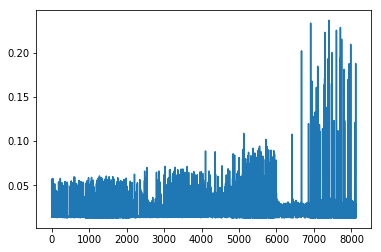

In [2]:
# Logistic Regression
loss = loss_logreg
grad = grad_logreg
grad_i = grad_i_logreg
lipschitz_constant = lipschitz_logreg
mu_constant = mu_constant_logreg

dataname = "mushrooms"   
A, b = get_data(dataname)
n, d = A.shape;
A = A.toarray()
print("Size of the Dataset (n, d) = ", n, d)

# Setup
n_iter = 45
x_0 = 1*np.ones(d)
lbda = 1.00001 / n ** (0.5) 
store_every = n

# Initialization
mu = mu_constant(A, b, lbda) #0.011094797642331011  
L = lipschitz_constant(A, b, lbda) #2.5973090315467626#
print("\lambda = %s" % lbda)
print("\mu = %s" % mu )
print("L = %s" % L )

### Get a very precise minimum to compute distances to minimum

from scipy.optimize import check_grad
check_grad(loss, grad, np.random.randn(d), A, b, lbda)
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad,
                                args=(A, b, lbda), pgtol=1e-30, factr=1e-30)

gradient_memory = np.zeros((n, d))
g_norm = np.zeros(n)
for j in range(n):
    gradient_memory[j] = grad_i(j, x_min, A, b ,lbda)
    g_norm[j] = norm(gradient_memory[j])
    
plt.plot(g_norm)

# SGD

In [4]:
from stochastic_methods import str_sgd
np.random.seed(0)
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
L_i_max = 0.25 * max_squared_sum + lbda

n_reps = 50
x_init = x_min + x_0.copy()* 0.5*10**(-1) 
step_size = 1/L * 2 
store_every = 1
n_steps = 1000

print('dimension:', d)
print("SGD step-size = %s" % step_size)
visited_distances_str_sgd = np.zeros((n_reps, n_steps+1)) 
for rep in range(n_reps):
    rep_x_final, rep_visited_points = str_sgd(n, x_init, grad_i, store_every, step_size, n_steps,  args=(A, b, lbda))
    rep_visited_distances = [ np.linalg.norm(visited_point - x_min) for visited_point in rep_visited_points]
    visited_distances_str_sgd[rep, :] = rep_visited_distances
    if (rep+1) % 25 == 0:
        print(rep+1)

dimension: 112
SGD step-size = 0.7700277385971857
25
50


In [5]:
from stochastic_methods import str_sgd_COCO
np.random.seed(0)

K = 2
L = L
tol= 10**(0) 

print("SGD step-size = %s" % step_size)
visited_distances_str_sgd_COCO2 = np.zeros((n_reps, n_steps+1)) 
for rep in range(n_reps):
    rep_x_final, rep_visited_points = str_sgd_COCO(n, K, L, tol, x_init, grad_i, store_every, step_size, n_steps,  args=(A, b, lbda))
    rep_visited_distances = [ np.linalg.norm(visited_point - x_min) for visited_point in rep_visited_points]
    visited_distances_str_sgd_COCO2[rep, :] = rep_visited_distances
    if (rep+1) % 25 == 0:
        print(rep+1)

SGD step-size = 0.7700277385971857
25
50


In [6]:
from stochastic_methods import str_sgd_COCO
np.random.seed(0)

K = 4
L = L
tol= 10**(0)

print("SGD step-size = %s" % step_size)
visited_distances_str_sgd_COCO4 = np.zeros((n_reps, n_steps+1)) 
for rep in range(n_reps):
    t = time.time()
    rep_x_final, rep_visited_points = str_sgd_COCO(n, K, L, tol, x_init, grad_i, store_every, step_size, n_steps,  args=(A, b, lbda))
    rep_visited_distances = [ np.linalg.norm(visited_point - x_min) for visited_point in rep_visited_points]
    visited_distances_str_sgd_COCO4[rep, :] = rep_visited_distances
    if (rep+1) % 25 == 0:
        print(rep+1)

SGD step-size = 0.7700277385971857


KeyboardInterrupt: 

In [7]:
from stochastic_methods import str_sgd_COCO
np.random.seed(0)
K = 8
L = L
tol= 10**(0) 

print("SGD step-size = %s" % step_size)
visited_distances_str_sgd_COCO8 = np.zeros((n_reps, n_steps+1)) 
for rep in range(n_reps):
    t = time.time()
    rep_x_final, rep_visited_points = str_sgd_COCO(n, K, L, tol, x_init, grad_i, store_every, step_size, n_steps,  args=(A, b, lbda))
    rep_visited_distances = [ np.linalg.norm(visited_point - x_min) for visited_point in rep_visited_points]
    visited_distances_str_sgd_COCO8[rep, :] = rep_visited_distances
    if (rep+1) % 25 == 0:
        print(rep+1)

SGD step-size = 0.7700277385971857


KeyboardInterrupt: 

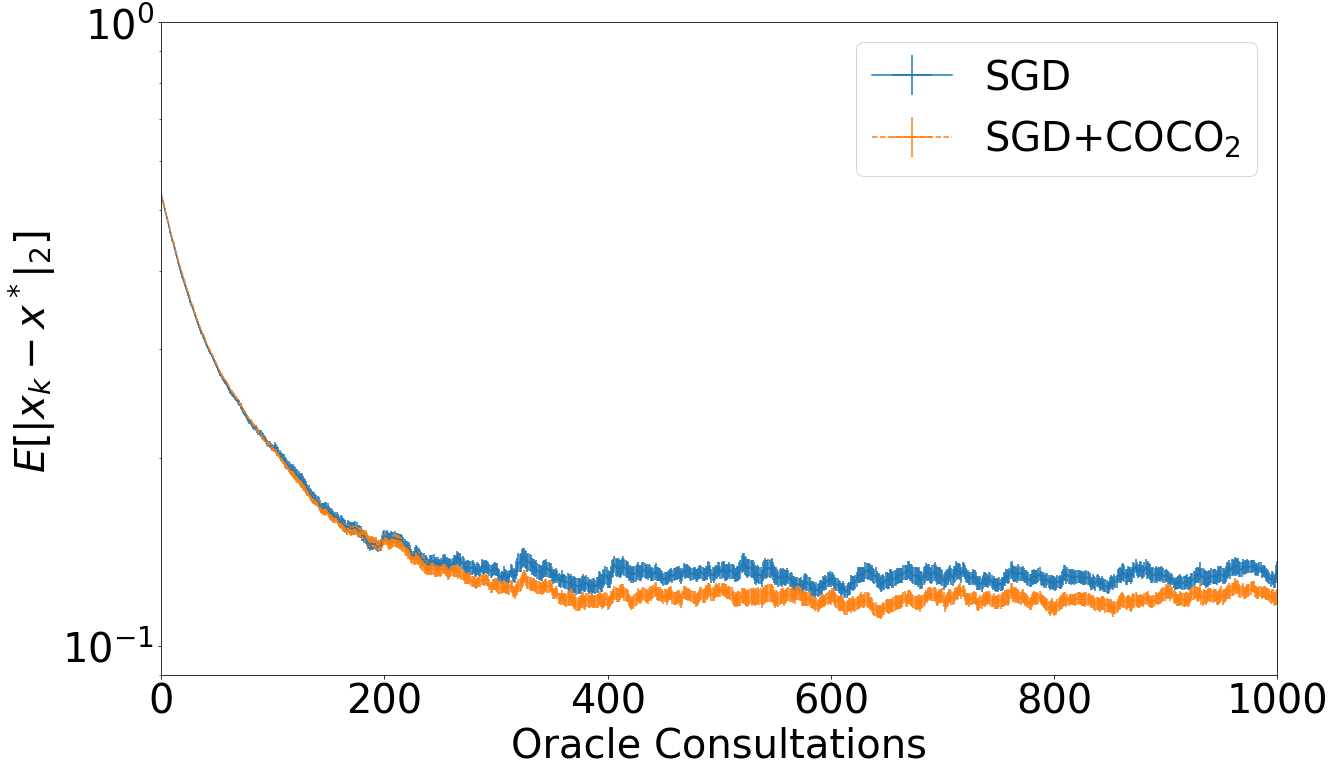

In [10]:
def plot_epochs(visited_distances_mtxs, solvers):
    
    fig, ax = plt.subplots(figsize=(20, 12))
    linestyles = ['-', '--', '--', '-.', ':', '--', '-']
    ls = 0
    x = np.arange(n_steps+1)
    for mtx in visited_distances_mtxs:
        mean = np.mean(mtx, axis=0)
        std = np.std(mtx, axis=0)/math.sqrt(n_reps)
        ax.errorbar(x, mean, xerr=0, yerr=std, linestyle=linestyles[ls])
        ax.set_yscale('log')
        ls +=1
         
    plt.xlabel("Oracle Consultations", fontsize=40)
    plt.ylabel("$E[\|x_k - x^*\|_2]$ ", fontsize=40)
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    plt.legend(solvers, fontsize=40)
    plt.xlim([0, 1000])
    plt.ylim([9*10**(-2), 1*10**(0)])
    plt.savefig('mushrooms_SGD.pdf', bbox_inches='tight')

monitors = [visited_distances_str_sgd, visited_distances_str_sgd_COCO2, visited_distances_str_sgd_COCO4, visited_distances_str_sgd_COCO8]  
solvers = ["SGD","SGD$+$COCO$_2$", "SGD$+$COCO$_4$", "SGD$+$COCO$_8$"]
plot_epochs(monitors, solvers)

# Adam

In [37]:
from stochastic_methods import str_adam
np.random.seed(0)
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
L_i_max = 0.25 * max_squared_sum + lbda

n_reps = 50
x_init = x_0.copy() # x_min + x_0.copy()* 0.5*10**(-1)
step_size = 10**(-1) #10**(-1) #1/L * 2 #1/L * 80  #1/L_i_max  #1.0 / (10*max_squared_sum + lbda)
store_every = 1
n_steps = 200
beta1 = 0.9
beta2 = 0.999
epsilon = 10**(-8)
print('dimension:', d)

print("SGD step-size = %s" % step_size)
visited_distances_str_adam = np.zeros((n_reps, n_steps+1)) 
for rep in range(n_reps):
    rep_x_final, rep_visited_points = str_adam(x_init, grad_i, store_every, step_size, n_steps, beta1, beta2, epsilon, args=(A, b, lbda))
    rep_visited_distances = [ np.linalg.norm(visited_point - x_min) for visited_point in rep_visited_points]
    visited_distances_str_adam[rep, :] = rep_visited_distances
    if (rep+1) % 25 == 0:
        print(rep+1)

dimension: 112
SGD step-size = 0.1
25
50


In [38]:
from stochastic_methods import str_adam_COCO
np.random.seed(0)

K = 2
L = L
tol= 10**(0) 

print("SGD step-size = %s" % step_size)
visited_distances_str_adam_COCO2 = np.zeros((n_reps, n_steps+1)) 
for rep in range(n_reps):
    rep_x_final, rep_visited_points = str_adam_COCO(n, K, L, tol, x_init, grad_i, store_every, step_size, n_steps, beta1, beta2, epsilon, args=(A, b, lbda))
    rep_visited_distances = [ np.linalg.norm(visited_point - x_min) for visited_point in rep_visited_points]
    visited_distances_str_adam_COCO2[rep, :] = rep_visited_distances
    if (rep+1) % 25 == 0:
        print(rep+1)

SGD step-size = 0.1
25
50


In [39]:
from stochastic_methods import str_adam_COCO
np.random.seed(0)

K = 4
L = L
tol= 10**(-3) 

print("SGD step-size = %s" % step_size)
visited_distances_str_adam_COCO4 = np.zeros((n_reps, n_steps+1)) 
for rep in range(n_reps):
    t = time.time()
    rep_x_final, rep_visited_points = str_adam_COCO(n, K, L, tol, x_init, grad_i, store_every, step_size, n_steps, beta1, beta2, epsilon, args=(A, b, lbda))
    rep_visited_distances = [ np.linalg.norm(visited_point - x_min) for visited_point in rep_visited_points]
    visited_distances_str_adam_COCO4[rep, :] = rep_visited_distances
    if (rep+1) % 25 == 0:
        print(rep+1)

SGD step-size = 0.1
25
50


In [ ]:
from stochastic_methods import str_adam_COCO
np.random.seed(0)

K = 8
L = L
tol= 10**(1) 

print("SGD step-size = %s" % step_size)
visited_distances_str_adam_COCO8 = np.zeros((n_reps, n_steps+1)) 
for rep in range(n_reps):
    t = time.time()
    rep_x_final, rep_visited_points = str_adam_COCO(n, K, L, tol, x_init, grad_i, store_every, step_size, n_steps, beta1, beta2, epsilon, args=(A, b, lbda))
    rep_visited_distances = [ np.linalg.norm(visited_point - x_min) for visited_point in rep_visited_points]
    visited_distances_str_adam_COCO8[rep, :] = rep_visited_distances
    if (rep+1) % 25 == 0:
        print(rep+1)

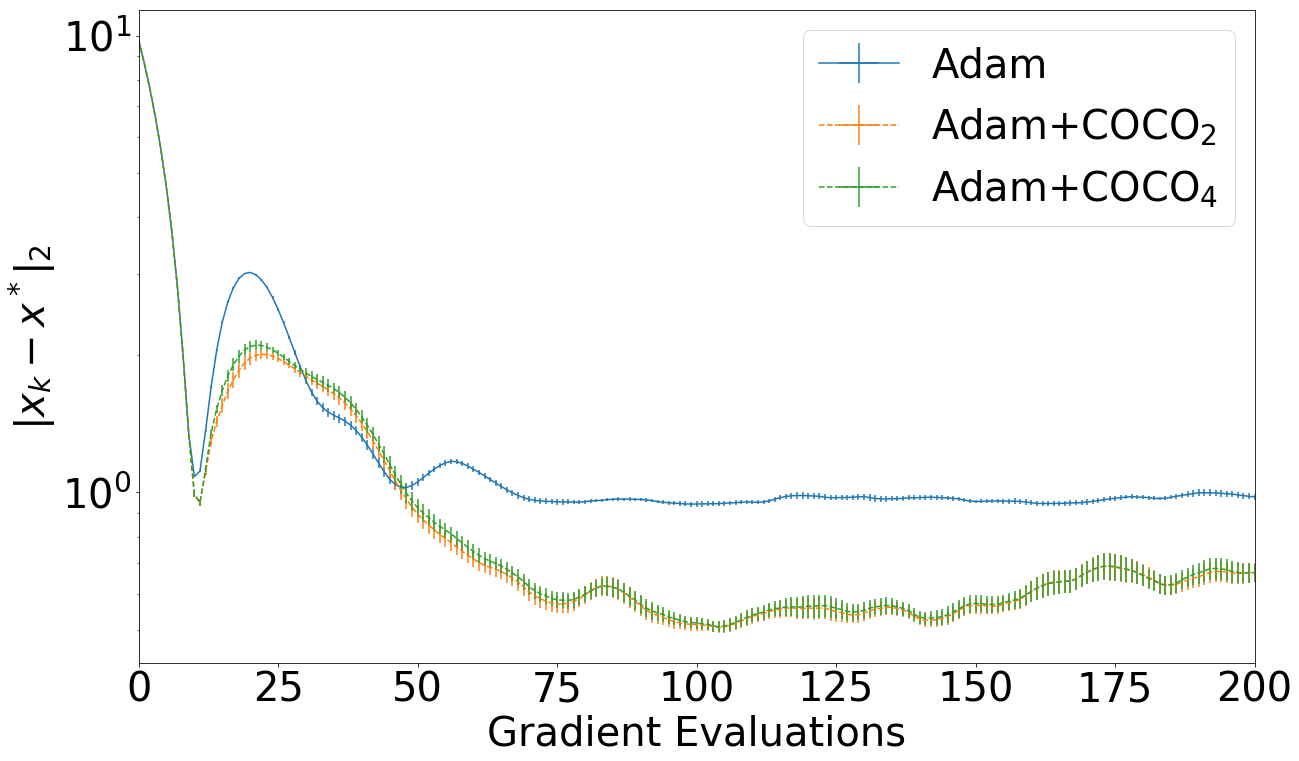

In [40]:
def plot_epochs(visited_distances_mtxs, solvers):
    
    fig, ax = plt.subplots(figsize=(20, 12))
    linestyles = ['-', '--', '--', '-.', ':', '--', '-']
    ls = 0
    x = np.arange(n_steps+1)
    for mtx in visited_distances_mtxs:
        mean = np.mean(mtx, axis=0)
        std = np.std(mtx, axis=0)/math.sqrt(n_reps)
        
        ax.errorbar(x, mean, xerr=0, yerr=std, linestyle=linestyles[ls])
        ax.set_yscale('log')
        plt.xlabel("Gradient Evaluations", fontsize=40)
        plt.ylabel("$\|x_k - x^*\|_2$", fontsize=40)
        ls +=1

    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    plt.legend(solvers, fontsize=40)
    plt.xlim([0, 200])
    plt.savefig('mushrooms_adam.pdf', bbox_inches='tight')

monitors = [visited_distances_str_adam, visited_distances_str_adam_COCO2, visited_distances_str_adam_COCO4, visited_distances_str_adam_COCO8]
solvers = ["Adam","Adam$+$COCO$_2$", "Adam$+$COCO$_4$", "Adam$+$COCO$_8$"]
plot_epochs(monitors, solvers)

# strSAGA

In [41]:
from stochastic_methods import str_saga
np.random.seed(0)
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
L_i_max = 0.25 * max_squared_sum + lbda

n_reps = 50
x_init = x_min + x_0.copy()* 0.5*10**(-1) 
step_size = 1/L * 4 
store_every = 1
n_steps = 1000
rho = 1
n = n

print('dimension:', d)
print("SAGA step-size = %s" % step_size)
visited_distances_str_saga = np.zeros((n_reps, n_steps+1))
for rep in range(n_reps):
    rep_x_final, rep_visited_points = str_saga(rho, n, x_init, grad_i, store_every, step_size, n_steps,  args=(A, b, lbda))
    rep_visited_distances = [ np.linalg.norm(visited_point - x_min) for visited_point in rep_visited_points]
    visited_distances_str_saga[rep, :] = rep_visited_distances
    if (rep+1) % 25 == 0:
        print(rep+1)

dimension: 112
SAGA step-size = 1.5400554771943713
25
50


In [42]:
from stochastic_methods import str_saga_COCO
np.random.seed(0)

K = 2
L = L
tol= 10**(1) 

print("SGD step-size = %s" % step_size)
visited_distances_str_saga_COCO2 = np.zeros((n_reps, n_steps+1)) 
for rep in range(n_reps):
    rep_x_final, rep_visited_points = str_saga_COCO(K, L, tol, rho, n, x_init,  grad_i, store_every, step_size, n_steps, args=(A, b, lbda))
    rep_visited_distances = [ np.linalg.norm(visited_point - x_min) for visited_point in rep_visited_points]
    visited_distances_str_saga_COCO2[rep, :] = rep_visited_distances
    if (rep+1) % 25 == 0:
        print(rep+1)

SGD step-size = 1.5400554771943713
25
50


In [43]:
from stochastic_methods import str_saga_COCO
np.random.seed(0)

K = 4
L = L
tol= 10**(0) 

print("SGD step-size = %s" % step_size)
visited_distances_str_saga_COCO4 = np.zeros((n_reps, n_steps+1)) 
for rep in range(n_reps):
    t = time.time()
    rep_x_final, rep_visited_points = str_saga_COCO(K, L, tol, rho, n, x_init,  grad_i, store_every, step_size, n_steps, args=(A, b, lbda))
    rep_visited_distances = [ np.linalg.norm(visited_point - x_min) for visited_point in rep_visited_points]
    visited_distances_str_saga_COCO4[rep, :] = rep_visited_distances
    if (rep+1) % 25 == 0:
        print(rep+1)

SGD step-size = 1.5400554771943713


KeyboardInterrupt: 

In [44]:
from stochastic_methods import str_saga_COCO
np.random.seed(0)

K = 8
L = L
tol= 10**(0) 

print("SGD step-size = %s" % step_size)
visited_distances_str_saga_COCO8 = np.zeros((n_reps, n_steps+1)) 
for rep in range(n_reps):
    t = time.time()
    rep_x_final, rep_visited_points = str_saga_COCO(K, L, tol, rho, n, x_init,  grad_i, store_every, step_size, n_steps, args=(A, b, lbda))
    rep_visited_distances = [ np.linalg.norm(visited_point - x_min) for visited_point in rep_visited_points]
    visited_distances_str_saga_COCO8[rep, :] = rep_visited_distances
    if (rep+1) % 25 == 0:
            print(rep+1)

SGD step-size = 1.5400554771943713


KeyboardInterrupt: 

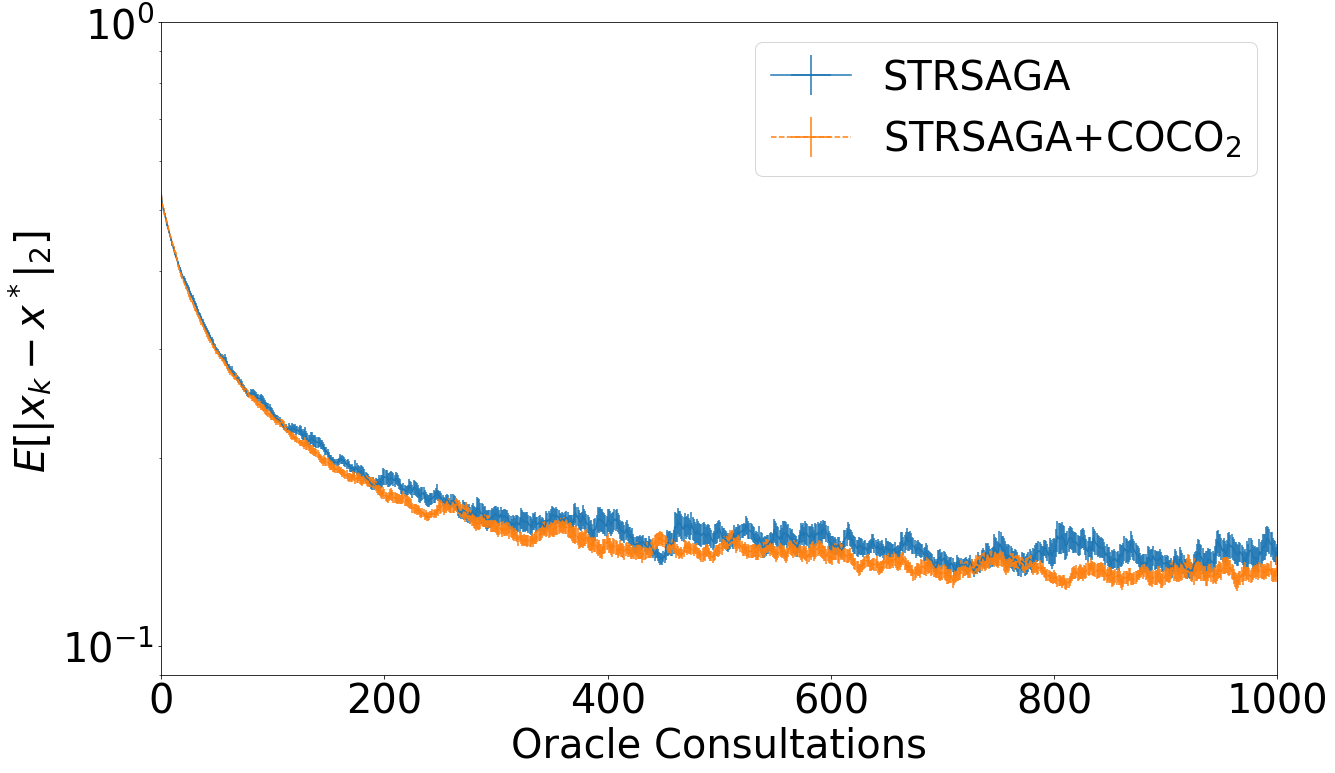

In [45]:
def plot_epochs(visited_distances_mtxs, solvers):
    
    fig, ax = plt.subplots(figsize=(20, 12))
    linestyles = ['-', '--', '--', '-.', ':', '--', '-', '--', '--', '-.', ':', '--', '-']
    ls = 0
    x = np.arange(n_steps+1)
    for mtx in visited_distances_mtxs:
        mean = np.mean(mtx, axis=0)
        std = np.std(mtx, axis=0)/math.sqrt(n_reps)
        ax.errorbar(x, mean, xerr=0, yerr=std, linestyle=linestyles[ls])
        ax.set_yscale('log')
        plt.xlabel("Oracle Consultations", fontsize=40)
        plt.ylabel("$E[\|x_k - x^*\|_2]$ ", fontsize=40)
        ls +=1

    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    plt.legend(solvers, fontsize=40)
    plt.xlim([0, 1000])
    plt.ylim([9*10**(-2), 1*10**(0)])
    plt.savefig('mushrooms_strsaga.pdf', bbox_inches='tight')

monitors = [visited_distances_str_saga, visited_distances_str_saga_COCO2, visited_distances_str_saga_COCO4, visited_distances_str_saga_COCO8]
solvers = ["STRSAGA", "STRSAGA$+$COCO$_2$", "STRSAGA$+$COCO$_4$", "STRSAGA$+$COCO$_8$"]
plot_epochs(monitors, solvers)